In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
labels_per_class = 'full' # full

### Load packages

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [6]:
from tfumap.load_datasets import load_MNIST, mask_labels
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_MNIST(flatten=False)
X_train.shape

(50000, 28, 28, 1)

In [7]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Network architecture

In [8]:
dims = (28,28,1)
n_components= 2

### Test model with just UMAP

In [9]:
from tfumap.semisupervised import find_a_b
from tfumap.umap import convert_distance_to_probability

In [10]:
min_dist = 0.001
_a, _b = find_a_b(min_dist)
_a, _b 

(<tf.Tensor: shape=(), dtype=float32, numpy=1.9290735>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.79150456>)

##### build iterator

In [11]:
from tfumap.semisupervised import build_fuzzy_simplicial_set
from tfumap.umap import compute_cross_entropy, get_graph_elements

In [12]:
n_neighbors = 15  # default = 15
umap_graph = build_fuzzy_simplicial_set(
    X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:]))),
    #y=Y_masked,
    n_neighbors=n_neighbors,
)

In [13]:
umap_graph.nnz

1030594

In [14]:
n_epochs = 200
graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
            umap_graph, n_epochs
)

### initialize embedding

In [15]:
from umap.spectral import spectral_layout

from sklearn.utils import check_random_state

random_state = check_random_state(None)
metric = "euclidean"
_metric_kwds = {}
def init_embedding_from_graph(_raw_data, graph, n_components, random_state, metric, _metric_kwds, init="spectral"):
        """ Initialize embedding using graph. This is for direct embeddings. 

        Parameters
        ----------
        init : str, optional
            Type of initialization to use. Either random, or spectral, by default "spectral"

        Returns
        -------
        embedding : np.array
            the initialized embedding
        """
        if isinstance(init, str) and init == "random":
            embedding = random_state.uniform(
                low=-10.0, high=10.0, size=(graph.shape[0], n_components)
            ).astype(np.float32)
        elif isinstance(init, str) and init == "spectral":
            # We add a little noise to avoid local minima for optimization to come

            initialisation = spectral_layout(
                _raw_data,
                graph,
                n_components,
                random_state,
                metric=metric,
                metric_kwds=_metric_kwds,
            )
            expansion = 10.0 / np.abs(initialisation).max()
            embedding = (initialisation * expansion).astype(
                np.float32
            ) + random_state.normal(
                scale=0.0001, size=[graph.shape[0], n_components]
            ).astype(
                np.float32
            )

        else:
            init_data = np.array(init)
            if len(init_data.shape) == 2:
                if np.unique(init_data, axis=0).shape[0] < init_data.shape[0]:
                    tree = KDTree(init_data)
                    dist, ind = tree.query(init_data, k=2)
                    nndist = np.mean(dist[:, 1])
                    embedding = init_data + random_state.normal(
                        scale=0.001 * nndist, size=init_data.shape
                    ).astype(np.float32)
                else:
                    embedding = init_data

        return embedding

In [16]:
embedding = init_embedding_from_graph(X_train, graph, n_components, random_state, metric, _metric_kwds, init="spectral")

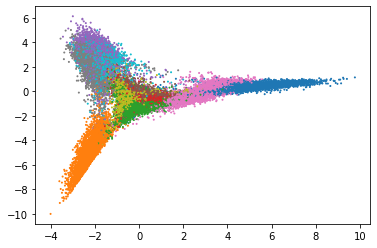

In [17]:
plt.scatter(embedding[:,0], embedding[:,1], c=Y_train, s=1, cmap=plt.cm.tab10)

### make iterator

In [39]:
batch_size =  60000

In [118]:
max_sample_repeats_per_epoch = 25
# set the maximum number of times each edge should be repeated per epoch
epochs_per_sample = np.clip(
    (weight / np.max(weight)) * max_sample_repeats_per_epoch,
    1,
    max_sample_repeats_per_epoch,
).astype("int")

In [119]:
edges_to_exp, edges_from_exp = (
        np.repeat(head, epochs_per_sample.astype("int")),
       np.repeat(tail, epochs_per_sample.astype("int")),
)

In [120]:
negative_sample_rate = 5

In [121]:
def make_gen_callable(n_edges, batch_size):
    def edge_generator():
        while True:
            yield tf.random.uniform(
                (batch_size, 1), minval=0, maxval=n_edges, dtype=tf.int32
            ), tf.zeros(1, dtype=tf.int32)

    return edge_generator

In [122]:
gen = make_gen_callable(len(edges_to_exp), batch_size)

In [123]:
n_edges = len(edges_to_exp)
n_edges

7709154

In [137]:
edge_iter = tf.data.Dataset.from_generator(gen, (tf.float32, tf.int32))
#edge_iter = edge_iter.prefetch(200)

In [138]:
a,c = next(iter(edge_iter))

In [139]:
for i in tqdm(zip(range(1000), edge_iter)):
    continue

#### Build network

In [140]:
def umap_loss(batch_size, negative_sample_rate, _a, _b, repulsion_strength = 1.0):
    @tf.function
    def loss(placeholder_y, embed_to_from):
        # split out to/from
        embedding_to, embedding_from = tf.split(embed_to_from, num_or_size_splits=2, axis=1)

        # get negative samples
        embedding_neg_to = tf.repeat(embedding_to, negative_sample_rate, axis=0)
        repeat_neg = tf.repeat(embedding_from, negative_sample_rate, axis=0)
        embedding_neg_from = tf.gather(
            repeat_neg, tf.random.shuffle(tf.range(tf.shape(repeat_neg)[0]))
        )

        #  distances between samples (and negative samples)
        distance_embedding = tf.concat(
            [
                tf.norm(embedding_to - embedding_from, axis=1),
                tf.norm(embedding_neg_to - embedding_neg_from, axis=1),
            ],
            axis=0,
        )

        # convert probabilities to distances
        probabilities_distance = convert_distance_to_probability(
            distance_embedding, _a, _b
        )
        
        # set true probabilities based on negative sampling
        probabilities_graph = tf.concat(
            [tf.ones(batch_size), tf.zeros(batch_size * negative_sample_rate)],
            axis=0,
        )
                
        # compute cross entropy
        (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
            probabilities_graph,
            probabilities_distance,
            repulsion_strength=repulsion_strength,
        )
        return tf.reduce_mean(ce_loss)

    return loss

In [141]:
from tensorflow.keras.layers import Input

In [142]:
"""class EmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, n_embeddings, embedding_dims):
        super(EmbeddingLayer, self).__init__()
        w_init = tf.random_normal_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(shape=(n_embeddings, embedding_dims), dtype="float32"),
            trainable=True,
        )
    def call(self, inputs):
        with tf.device('/device:GPU:0'):
            return tf.gather(self.embeddings, inputs)
        
n_data = len(X_train)
embedding_layer = EmbeddingLayer(n_data, n_components)
embedding_layer.set_weights([embedding])
encoder = tf.keras.Sequential([
    embedding_layer
])"""

'class EmbeddingLayer(tf.keras.layers.Layer):\n    def __init__(self, n_embeddings, embedding_dims):\n        super(EmbeddingLayer, self).__init__()\n        w_init = tf.random_normal_initializer()\n        self.embeddings = tf.Variable(\n            initial_value=w_init(shape=(n_embeddings, embedding_dims), dtype="float32"),\n            trainable=True,\n        )\n    def call(self, inputs):\n        with tf.device(\'/device:GPU:0\'):\n            return tf.gather(self.embeddings, inputs)\n        \nn_data = len(X_train)\nembedding_layer = EmbeddingLayer(n_data, n_components)\nembedding_layer.set_weights([embedding])\nencoder = tf.keras.Sequential([\n    embedding_layer\n])'

In [143]:
n_data = len(X_train)
embedding_layer = tf.keras.layers.Embedding(n_data, n_components, input_length=1)
embedding_layer.build(input_shape=(1,)) # the input_shape here has no effect in the build function
embedding_layer.set_weights([embedding])
encoder = embedding_layer

In [144]:
n_edges = tf.constant(len(edges_to_exp))
to_ = tf.constant(edges_to_exp)
from_ = tf.constant(edges_from_exp)

In [145]:
batch_sample = Input(shape=(1), dtype=tf.float32, name = "to_x")

to_x = tf.gather(to_, tf.cast(batch_sample, tf.int32))
from_x = tf.gather(from_, tf.cast(batch_sample, tf.int32))

embedding_to = encoder(to_x)[:,-1,:]
embedding_from = encoder(from_x)[:,-1,:]

embedding_to_from = tf.keras.layers.concatenate([embedding_to, embedding_from],axis=1)
embedding_to_from = tf.keras.layers.Lambda(lambda x: x, name='umap')(embedding_to_from)
model = tf.keras.Model(
    inputs=[batch_sample],
    outputs=[embedding_to_from],#[embedding_to_from],
)

In [146]:
embedding_to

<tf.Tensor 'strided_slice_6:0' shape=(None, 2) dtype=float32>

In [153]:
opt = tf.keras.optimizers.Adadelta(learning_rate=50)
#opt = tf.keras.optimizers.SGD(learning_rate=1.0)
opt = tf.keras.optimizers.Adam(learning_rate=0.1)

In [154]:
model.compile(
    optimizer=opt,
    loss=umap_loss(batch_size, negative_sample_rate, _a, _b)
)
model.inputs, model.outputs

([<tf.Tensor 'to_x_3:0' shape=(None, 1) dtype=float32>],
 [<tf.Tensor 'umap/umap_3/Identity:0' shape=(None, 4) dtype=float32>])

In [155]:
history = model.fit(
    edge_iter,
    epochs=100,    
    steps_per_epoch=n_edges/batch_size,
    max_queue_size = 20
)

Epoch 1/100
129/128 [==============================] - 3s 19ms/step - loss: 0.1615
Epoch 2/100
129/128 [==============================] - 3s 20ms/step - loss: 0.1362
Epoch 3/100
129/128 [==============================] - 3s 20ms/step - loss: 0.1302
Epoch 4/100
129/128 [==============================] - 2s 19ms/step - loss: 0.1261
Epoch 5/100
129/128 [==============================] - 3s 20ms/step - loss: 0.1244
Epoch 6/100
129/128 [==============================] - 2s 19ms/step - loss: 0.1228
Epoch 7/100
129/128 [==============================] - 3s 20ms/step - loss: 0.1211
Epoch 8/100
129/128 [==============================] - 3s 19ms/step - loss: 0.1203
Epoch 9/100
129/128 [==============================] - 3s 19ms/step - loss: 0.1199
Epoch 10/100
129/128 [==============================] - 3s 20ms/step - loss: 0.1187
Epoch 11/100
129/128 [==============================] - 3s 20ms/step - loss: 0.1181
Epoch 12/100
129/128 [==============================] - 2s 19ms/step - loss: 0.1178
E

In [ ]:
z = encoder(np.arange(len(X_train)))

fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

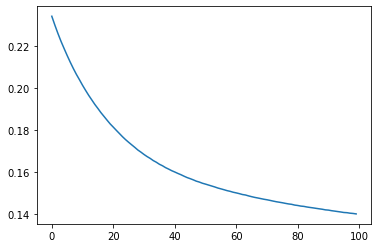

In [61]:
plt.plot(history.history['loss'])

In [115]:
x_tensor = tf.convert_to_tensor(in_, dtype=tf.int32)
with tf.GradientTape() as t:
    t.watch(x_tensor)
    loss = umap_loss(batch_size, negative_sample_rate, _a, _b)(0, model(x_tensor))

W0812 23:51:22.686504 139807779141440 backprop.py:900] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int32


In [1]:
loss

NameError: name 'loss' is not defined

In [116]:
t.gradient(loss, x_tensor)

W0812 23:51:23.571452 139807779141440 backprop.py:1057] The dtype of the source tensor must be floating (e.g. tf.float32) when calling GradientTape.gradient, got tf.int32


RuntimeError: GradientTape.gradient can only be called once on non-persistent tapes.

In [78]:
in_, out_ = next(iter(edge_iter))

In [83]:
grad =  get_weight_grad(model, in_, out_)

TypeError: Failed to convert object of type <class 'tensorflow.python.eager.def_function.Function'> to Tensor. Contents: <tensorflow.python.eager.def_function.Function object at 0x7f26671b46d8>. Consider casting elements to a supported type.